In [1]:
import tensorflow as tf
import os
from tensorflow.keras import utils, datasets, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# location of data
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# download the data and extract it
path_to_zip = utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

# construct paths
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# parameters for datasets
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# construct train and validation datasets 
train_dataset = utils.image_dataset_from_directory(train_dir,
                                                   shuffle=True,
                                                   batch_size=BATCH_SIZE,
                                                   image_size=IMG_SIZE)

validation_dataset = utils.image_dataset_from_directory(validation_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)

# construct the test dataset by taking every 5th observation out of the validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

68616192/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

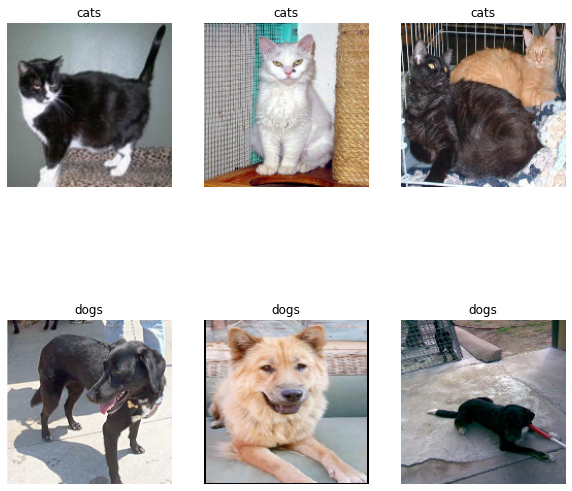

In [5]:
plt.figure(figsize=(10, 10))
dataset = train_dataset.take(1)

def plot_images(dataset):
  for images, labels in dataset:
    for i in range(3):
      pic = np.random.randint(32)
      ax = plt.subplot(2, 3, i + 1)
      while(labels[pic]!=0):
        pic = np.random.randint(32)
      plt.imshow(images[pic].numpy().astype("uint8"))
      plt.title("cats")
      plt.axis("off")
    for i in range(3,6):
      pic = np.random.randint(32)
      ax = plt.subplot(2, 3, i + 1)
      while(labels[pic]!=1):
        pic = np.random.randint(32)
      plt.imshow(images[pic].numpy().astype("uint8"))
      plt.title("dogs")
      plt.axis("off")
plot_images(dataset)

In [6]:
labels_iterator= train_dataset.unbatch().map(lambda image, label: label).as_numpy_iterator()

In [15]:
dog_count = 0
cat_count = 0
for label in labels_iterator:
  if (label==0):
    cat_count +=1
  else:
    dog_count +=1
print(dog_count, cat_count)

1000 1000


each label is equally frequent; thus our baseline should be 50%.

# Model 1

In [107]:
model1 = tf.keras.models.Sequential([
    layers.Conv2D(16, 3, activation='relu', input_shape=(160, 160, 3)),
    layers.MaxPooling2D(2),
    
    layers.Conv2D(32, 3, activation='relu'),
    layers.Dropout(0.3),
    layers.MaxPooling2D(2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='sigmoid')
])

In [108]:
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model1.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 158, 158, 16)      448       
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 79, 79, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 77, 77, 32)        4640      
                                                                 
 dropout_29 (Dropout)        (None, 77, 77, 32)        0         
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 38, 38, 32)       0         
 g2D)                                                            
                                                                 
 flatten_26 (Flatten)        (None, 46208)           

In [109]:
history = model1.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 42s 654ms/step - loss: 52.1842 - accuracy: 0.5550 - val_loss: 0.8020 - val_accuracy: 0.5903
Epoch 2/20
63/63 [==============================] - 41s 651ms/step - loss: 0.5982 - accuracy: 0.6890 - val_loss: 0.7697 - val_accuracy: 0.5792
Epoch 3/20
63/63 [==============================] - 41s 652ms/step - loss: 0.3951 - accuracy: 0.8110 - val_loss: 0.9076 - val_accuracy: 0.6052
Epoch 4/20
63/63 [==============================] - 41s 650ms/step - loss: 0.2503 - accuracy: 0.9120 - val_loss: 0.9572 - val_accuracy: 0.6225
Epoch 5/20
63/63 [==============================] - 41s 650ms/step - loss: 0.1366 - accuracy: 0.9550 - val_loss: 1.0849 - val_accuracy: 0.6312
Epoch 6/20
63/63 [==============================] - 41s 654ms/step - loss: 0.0766 - accuracy: 0.9800 - val_loss: 1.2641 - val_accuracy: 0.6052
Epoch 7/20
63/63 [==============================] - 41s 650ms/step - loss: 0.0633 - accuracy: 0.9840 - val_loss: 1.5458 - val_accuracy: 0.602

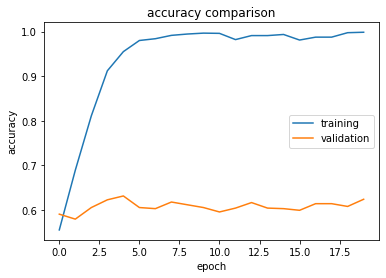

In [111]:
plt.plot(history.history['accuracy'], label="training")
plt.plot(history.history['val_accuracy'], label="validation")
plt.gca().set(xlabel="epoch", ylabel="accuracy", title="accuracy comparison")
plt.legend()

# model2

In [57]:
random_flip = layers.experimental.preprocessing.RandomFlip()
random_rotate = layers.RandomRotation(0.2)

<Figure size 720x720 with 0 Axes>

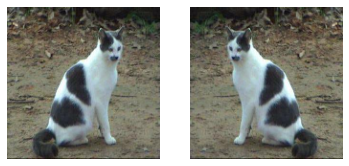

In [55]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
      pic = np.random.randint(32)
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(images[pic].numpy().astype("uint8"))
      ax[0].axis("off")
      ax[1].imshow(random_flip(images[pic]).numpy().astype("uint8"))
      ax[1].axis("off")

<Figure size 720x720 with 0 Axes>

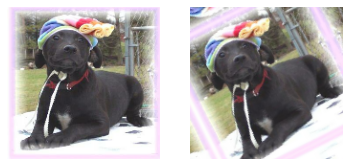

In [59]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
      pic = np.random.randint(32)
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(images[pic].numpy().astype("uint8"))
      ax[0].axis("off")
      ax[1].imshow(random_rotate(images[pic]).numpy().astype("uint8"))
      ax[1].axis("off")

In [113]:
model2 = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(),
    layers.experimental.preprocessing.RandomRotation(0.2),

    layers.Conv2D(16, 3, activation='relu', input_shape=(160, 160, 3)),
    layers.MaxPooling2D(2),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='sigmoid')
  ])

In [114]:
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [127]:
history = model2.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 30s 466ms/step - loss: 0.8256 - accuracy: 0.5960 - val_loss: 0.9537 - val_accuracy: 0.5705
Epoch 2/20
63/63 [==============================] - 30s 466ms/step - loss: 0.7919 - accuracy: 0.6120 - val_loss: 1.0236 - val_accuracy: 0.5705
Epoch 3/20
63/63 [==============================] - 30s 466ms/step - loss: 0.8308 - accuracy: 0.5815 - val_loss: 1.0335 - val_accuracy: 0.5681
Epoch 4/20
63/63 [==============================] - 30s 465ms/step - loss: 0.7562 - accuracy: 0.5990 - val_loss: 0.9561 - val_accuracy: 0.5668
Epoch 5/20
63/63 [==============================] - 30s 467ms/step - loss: 0.7468 - accuracy: 0.6055 - val_loss: 0.8913 - val_accuracy: 0.5891
Epoch 6/20
63/63 [==============================] - 30s 471ms/step - loss: 0.7441 - accuracy: 0.5955 - val_loss: 0.9911 - val_accuracy: 0.5755
Epoch 7/20
63/63 [==============================] - 30s 471ms/step - loss: 0.7159 - accuracy: 0.6030 - val_loss: 0.8608 - val_accuracy: 0.5965

In [128]:
model2.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_25 (RandomFlip)  (None, 160, 160, 3)      0         
                                                                 
 random_rotation_21 (RandomR  (None, 160, 160, 3)      0         
 otation)                                                        
                                                                 
 conv2d_47 (Conv2D)          (None, 158, 158, 16)      448       
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 79, 79, 16)       0         
 g2D)                                                            
                                                                 
 flatten_27 (Flatten)        (None, 99856)             0         
                                                                 
 dense_53 (Dense)            (None, 64)              

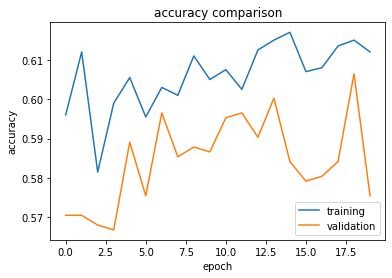

In [129]:
plt.plot(history.history['accuracy'], label="training")
plt.plot(history.history['val_accuracy'], label="validation")
plt.gca().set(xlabel="epoch", ylabel="accuracy", title="accuracy comparison")
plt.legend()

# model 3

In [118]:
i = tf.keras.Input(shape=(160, 160, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(i)
preprocessor = tf.keras.Model(inputs = [i], outputs = [x])

In [141]:
model3 = tf.keras.Sequential([
    preprocessor,

    layers.experimental.preprocessing.RandomFlip(),
    layers.experimental.preprocessing.RandomRotation(0.2),

    layers.Conv2D(16, 3, activation='relu', input_shape=(160, 160, 3)),
    layers.MaxPooling2D(2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Dropout(0.3),
    layers.MaxPooling2D(2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='sigmoid')
  ])

In [142]:
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model3.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 160, 160, 3)       0         
                                                                 
 random_flip_31 (RandomFlip)  (None, 160, 160, 3)      0         
                                                                 
 random_rotation_27 (RandomR  (None, 160, 160, 3)      0         
 otation)                                                        
                                                                 
 conv2d_54 (Conv2D)          (None, 158, 158, 16)      448       
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 79, 79, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 77, 77, 32)      

In [143]:
history = model3.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 47s 727ms/step - loss: 0.8419 - accuracy: 0.5280 - val_loss: 0.6853 - val_accuracy: 0.5631
Epoch 2/20
63/63 [==============================] - 46s 724ms/step - loss: 0.6748 - accuracy: 0.5680 - val_loss: 0.6565 - val_accuracy: 0.5718
Epoch 3/20
63/63 [==============================] - 46s 725ms/step - loss: 0.6573 - accuracy: 0.6000 - val_loss: 0.6391 - val_accuracy: 0.6238
Epoch 4/20
63/63 [==============================] - 46s 725ms/step - loss: 0.6410 - accuracy: 0.6385 - val_loss: 0.6403 - val_accuracy: 0.6535
Epoch 5/20
63/63 [==============================] - 46s 726ms/step - loss: 0.6306 - accuracy: 0.6395 - val_loss: 0.6340 - val_accuracy: 0.6077
Epoch 6/20
63/63 [==============================] - 46s 727ms/step - loss: 0.6152 - accuracy: 0.6510 - val_loss: 0.6146 - val_accuracy: 0.6399
Epoch 7/20
63/63 [==============================] - 46s 727ms/step - loss: 0.6080 - accuracy: 0.6630 - val_loss: 0.6095 - val_accuracy: 0.6646

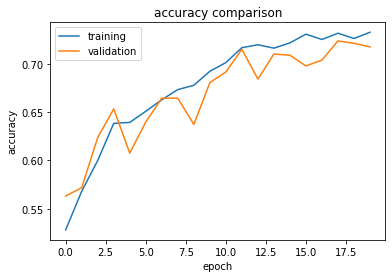

In [144]:
plt.plot(history.history['accuracy'], label="training")
plt.plot(history.history['val_accuracy'], label="validation")
plt.gca().set(xlabel="epoch", ylabel="accuracy", title="accuracy comparison")
plt.legend()

# model 4

In [130]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

i = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(i, training = False)
base_model_layer = tf.keras.Model(inputs = [i], outputs = [x])

9420800/9406464 [==============================] - 0s 0us/step


In [131]:
model4 = tf.keras.Sequential([
    preprocessor,

    layers.experimental.preprocessing.RandomFlip(),
    layers.experimental.preprocessing.RandomRotation(0.2),

    base_model_layer,

    

    layers.Flatten(),
    layers.Dense(2, activation='sigmoid')
  ])

In [132]:
model4.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model4.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 160, 160, 3)       0         
                                                                 
 random_flip_28 (RandomFlip)  (None, 160, 160, 3)      0         
                                                                 
 random_rotation_24 (RandomR  (None, 160, 160, 3)      0         
 otation)                                                        
                                                                 
 model_1 (Functional)        (None, 5, 5, 1280)        2257984   
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout_30 (Dropout)        (None, 1280)            

In [133]:
history = model4.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 48s 699ms/step - loss: 1.2159 - accuracy: 0.7400 - val_loss: 0.2403 - val_accuracy: 0.9344
Epoch 2/20
63/63 [==============================] - 43s 683ms/step - loss: 0.6893 - accuracy: 0.8455 - val_loss: 0.1401 - val_accuracy: 0.9653
Epoch 3/20
63/63 [==============================] - 43s 681ms/step - loss: 0.5432 - accuracy: 0.8680 - val_loss: 0.1252 - val_accuracy: 0.9666
Epoch 4/20
63/63 [==============================] - 43s 681ms/step - loss: 0.6301 - accuracy: 0.8610 - val_loss: 0.1319 - val_accuracy: 0.9691
Epoch 5/20
63/63 [==============================] - 43s 681ms/step - loss: 0.4667 - accuracy: 0.8850 - val_loss: 0.0998 - val_accuracy: 0.9740
Epoch 6/20
63/63 [==============================] - 43s 680ms/step - loss: 0.4977 - accuracy: 0.8880 - val_loss: 0.1036 - val_accuracy: 0.9678
Epoch 7/20
63/63 [==============================] - 43s 680ms/step - loss: 0.4543 - accuracy: 0.8880 - val_loss: 0.1494 - val_accuracy: 0.9542

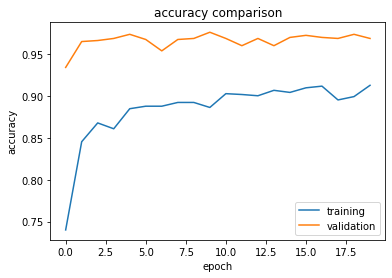

In [134]:
plt.plot(history.history['accuracy'], label="training")
plt.plot(history.history['val_accuracy'], label="validation")
plt.gca().set(xlabel="epoch", ylabel="accuracy", title="accuracy comparison")
plt.legend()

In [146]:
model4.evaluate(test_dataset)

6/6 [==============================] - 3s 446ms/step - loss: 0.0891 - accuracy: 0.9583


[0.08913678675889969, 0.9583333134651184]